# Estimation of FRET efficiency for emission from WS2 and absorption by diamond NV- center.

Based on Medintz & Hildebrandt, 2014, pages 23-31.

FRET efficiency, $E$, is
$$
E = \frac{R_0^6}{R_0^6 + r_{DA}^6}
$$
where
$r_{DA}$ is the distance between donor and acceptor
and 
$R_0$ is the Förster distance.
This is also expressed as
$$
E = \frac{k_T}{k_T + 1/\tau_D}
$$
where
$k_T$ is the rate of energy transfer
and $t_D$ is the lifetime of the donor excited state in the absence of acceptor.
The formula for $k_T$ is
$$
k_T = \frac{1}{\tau_D} \left( \frac{R_0^6}{r_{DA}^6} \right)
$$

The Förster distance $R_0^6$ is a key quantity to compute,
and is given as
$$
R_0^6 = \frac{9 (\ln 10) \kappa^2 \Phi_D J }{128\pi^5 n^4 N_A}
$$
where $\kappa^2$ is the orientation factor,
$\Phi_D$ is the quantum yield of the donor fluorescence in the absence of acceptor,
$J$ is the overlap integral,
$\pi = 3.14159...$,
$n$ is the index of refraction of the medium,
and $N_A$ is the Avogadro number $6.0221415 \times 10^{23}$ per mol.

The overlap integral $J$, is computed differently depending on whether the spectra are given in terms of wavelength, wave number, or frequency. For wavelength,
$$
J^\lambda = J = \int f_D(\lambda) \epsilon_A(\lambda) \lambda^4 \mathrm{d} \lambda
$$
where $f_D(\lambda)$ is the fluorescence spectrum of the donor,
$\epsilon_A(\lambda)$ is the molar extinction coefficient (a.k.a. molar absorptivity) of the acceptor (usually in units of $\mathrm{M}^{-1} \mathrm{cm}^{-1}$), and $\lambda$ is the wavelength (usually in nm).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def FRET_efficiency(kappa2, Phi_D, J, n, r_DA):
    R6_0 = forster_distance(kappa2, Phi_D, J, n)
    E = R6_0 / (R6_0 + r_DA**6)
    return E

def forster_distance(kappa2, Phi_D, J, n):
    N_A = 6.0221415e23 # Avogadro number, per mol
    numerator = 9*math.log(10)*kappa2*Phi_D*J
    denominator = 128*(math.pi**5)*(n**4)*N_A
    return numerator/denominator

kappa2 = 2./3 # orientation factor for dipole interaction
# "The orientation factor takes on a value of κ² = 2/3 for a dynamic and
# isotropic distribution of donor and acceptor orientations"
# "Varies between 0 and 4."

n_diamond = 2.417 # index of refraction of diamond
# "All refractive index values in the literature are in the 1.33 - 1.6 range.
# The values 1.34 and 1.6 are the ones used most frequently."

r_DA = 2. # 2 nm
# TODO: should this be 2e-9 or is OK to leave as 2 since lambda is in nm?
# c-axis of WS2 unit cell is 1.227 nm,
# In the literature, WS2 nanosheets are around 5-10 nm thick.
# FRET happens in the near field, that is, roughly in the 1-10 nm range."

Phi_D = 0.5
# TODO: find a better value for WS2 monolayer.
# "varies between 0 and 1"

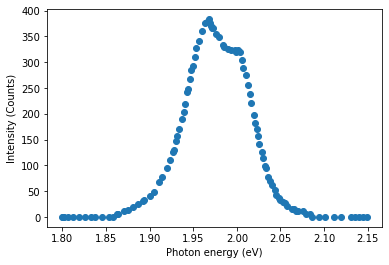

In [3]:
WS2_eV, WS2_intensity, _, _, _, _ = np.loadtxt("WS2_emission.txt", unpack=True)
plt.clf()
plt.scatter(WS2_eV, WS2_intensity)
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (Counts)");

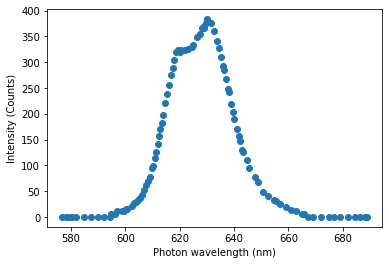

In [4]:
hc = 1239.8 # eV nm
WS2_nm = hc/WS2_eV
plt.clf()
plt.scatter(WS2_nm, WS2_intensity)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (Counts)");

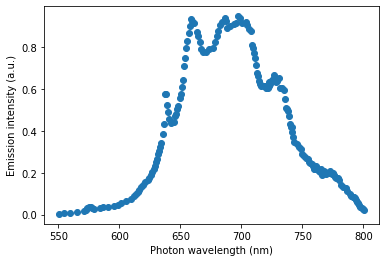

In [5]:
nv_center_nm, nv_center_intensity, _, _, _, _ = np.loadtxt("NV_center_absorption.txt", unpack=True)
plt.clf()
plt.scatter(nv_center_nm, nv_center_intensity)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Emission intensity (a.u.)");

Now let's see what they look like overlaid.

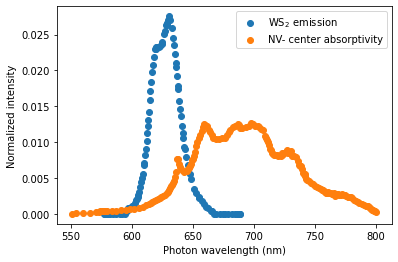

In [6]:
plt.clf()
plt.scatter(WS2_nm, WS2_intensity/WS2_intensity.sum(), label="$\mathrm{WS}_2$ emission")
plt.scatter(nv_center_nm, nv_center_intensity/nv_center_intensity.sum(), label="NV- center absorptivity")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

In [7]:
# Get a uniformly-spaced lambda range.
lambda_min = max(WS2_nm.min(),nv_center_nm.min())
lambda_max = min(WS2_nm.max(),nv_center_nm.max())
lambda_range = np.linspace(lambda_min, lambda_max, 100)

# I don't think I'll need this.
#WS2 = np.column_stack(WS2_nm, WS2_intensity)
#WS2_sort_order = WS2.argsort()
#WS2_nm_sorted = WS2_nm[WS2_sort_order]
#WS2_intensity_sorted = WS2_intensity[WS2_sort_order]

def correspond(template, search_in):
    # Find the order of the closest corresponding values.
    order = []
    for val in template:
        order.append(np.abs(val - search_in).argmin())
    return order

WS2_lambda_order = correspond(lambda_range, WS2_nm)
WS2_intensity_new = WS2_intensity[WS2_lambda_order]

nv_center_lambda_order = correspond(lambda_range, nv_center_nm)
nv_center_intensity_new = nv_center_intensity[nv_center_lambda_order]

def overlap(lambdas, donor_fluorescence, acceptor_extinction):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.sum()
    J = np.zeros(len(lambdas)-1)
    i = 0
    for wavelength, f_D, eps_A in zip(lambdas, f_D_norm, acceptor_extinction):
        if i == 0:
            # Skip the first one, i.e. use right-hand Riemann sum.
            wavelength_prev = wavelength
            i += 1
            continue
        dlambda = wavelength - wavelength_prev
        J[i-1] = f_D*eps_A*(wavelength**4)*dlambda
        i +=1
        wavelength_prev = wavelength
    return J

J_lambda = overlap(lambda_range, WS2_intensity_new, nv_center_intensity_new)

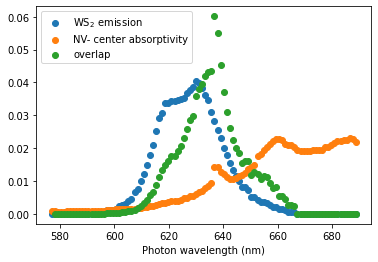

In [8]:
plt.clf()
plt.scatter(lambda_range, WS2_intensity_new/WS2_intensity_new.sum(), label="$\mathrm{WS}_2$ emission")
plt.scatter(lambda_range, nv_center_intensity_new/nv_center_intensity_new.sum(), label="NV- center absorptivity")
plt.scatter(lambda_range[1:], J_lambda/J_lambda.sum(), label="overlap")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

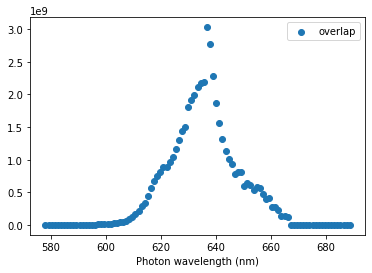

In [9]:
plt.clf()
plt.scatter(lambda_range[1:], J_lambda, label="overlap")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

In [10]:
J_sum = J_lambda.sum()
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, n_diamond, r_DA)
print(E_total)
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, 1.34, r_DA)
print(E_total)
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, 1.6, r_DA)
print(E_total)

6.7551962552541494e-21
7.150318365526233e-20
3.517747328423862e-20
